<a href="https://colab.research.google.com/github/anekekarina99/Time-Series-Forecasting/blob/main/Copy_of_Copy_of_TimeSeries_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
data = pd.read_csv('/content/energydata_complete.csv')
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
data.shape

(19735, 29)

In [7]:
data.dtypes

date            object
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
dtype: object

In [8]:
data.describe

<bound method NDFrame.describe of                       date  Appliances  lights  ...  Tdewpoint        rv1        rv2
0      2016-01-11 17:00:00          60      30  ...   5.300000  13.275433  13.275433
1      2016-01-11 17:10:00          60      30  ...   5.200000  18.606195  18.606195
2      2016-01-11 17:20:00          50      30  ...   5.100000  28.642668  28.642668
3      2016-01-11 17:30:00          50      40  ...   5.000000  45.410389  45.410389
4      2016-01-11 17:40:00          60      40  ...   4.900000  10.084097  10.084097
...                    ...         ...     ...  ...        ...        ...        ...
19730  2016-05-27 17:20:00         100       0  ...  13.333333  43.096812  43.096812
19731  2016-05-27 17:30:00          90       0  ...  13.300000  49.282940  49.282940
19732  2016-05-27 17:40:00         270      10  ...  13.266667  29.199117  29.199117
19733  2016-05-27 17:50:00         420      10  ...  13.233333   6.322784   6.322784
19734  2016-05-27 18:00:00     

In [9]:
data.info

<bound method DataFrame.info of                       date  Appliances  lights  ...  Tdewpoint        rv1        rv2
0      2016-01-11 17:00:00          60      30  ...   5.300000  13.275433  13.275433
1      2016-01-11 17:10:00          60      30  ...   5.200000  18.606195  18.606195
2      2016-01-11 17:20:00          50      30  ...   5.100000  28.642668  28.642668
3      2016-01-11 17:30:00          50      40  ...   5.000000  45.410389  45.410389
4      2016-01-11 17:40:00          60      40  ...   4.900000  10.084097  10.084097
...                    ...         ...     ...  ...        ...        ...        ...
19730  2016-05-27 17:20:00         100       0  ...  13.333333  43.096812  43.096812
19731  2016-05-27 17:30:00          90       0  ...  13.300000  49.282940  49.282940
19732  2016-05-27 17:40:00         270      10  ...  13.266667  29.199117  29.199117
19733  2016-05-27 17:50:00         420      10  ...  13.233333   6.322784   6.322784
19734  2016-05-27 18:00:00       

In [10]:
data.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [11]:
data['date']= pd.to_datetime(data['date'])

In [12]:
data['lights']= data['lights'].astype('float64') 

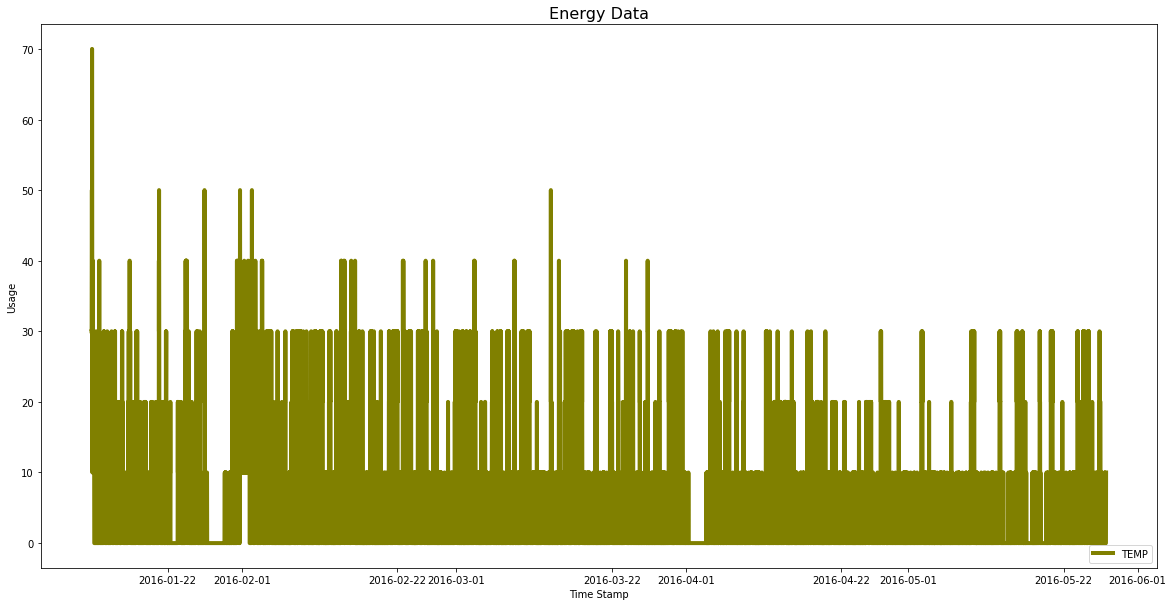

In [13]:
dates = data['date'].values
temp2  = data['lights'].values
 
plt.figure(figsize=(20,10))

plt.xlabel('Time Stamp')
plt.ylabel('Usage')
plt.title('Energy Data',
          fontsize=16);

plt.plot( dates, temp2,color='olive', linewidth=4)
plt.legend(['TEMP','TEMP2'], loc='lower right')

plt.show()

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(temp2, dates, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

15788 3947


In [38]:
# model
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=500)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=500)

model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(60, return_sequences=True),
            tf.keras.layers.LSTM(60),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 200)
])

In [42]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [43]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< 7.0):
      self.model.stop_training = True
      print("\nMAE of the model < 7% of data scale")
callbacks = myCallback()

In [46]:
history = model.fit(data_x_train ,epochs=200, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/200
158/158 [==============================] - 16s 100ms/step - loss: 8.5713 - mae: 9.0615 - val_loss: 22.4992 - val_mae: 22.9992
Epoch 2/200
158/158 [==============================] - 16s 100ms/step - loss: 8.9852 - mae: 9.4768 - val_loss: 2.1147 - val_mae: 2.6147
Epoch 3/200
158/158 [==============================] - 16s 102ms/step - loss: 8.5206 - mae: 9.0083 - val_loss: 1.9267 - val_mae: 2.3530
Epoch 4/200
158/158 [==============================] - 16s 99ms/step - loss: 7.8579 - mae: 8.3391 - val_loss: 6.2392 - val_mae: 6.7392
Epoch 5/200
158/158 [==============================] - 16s 99ms/step - loss: 8.8025 - mae: 9.2906 - val_loss: 20.1911 - val_mae: 20.6911
Epoch 6/200
158/158 [==============================] - 16s 100ms/step - loss: 7.1805 - mae: 7.6575 - val_loss: 2.4583 - val_mae: 2.9583
Epoch 7/200
158/158 [==============================] - 16s 102ms/step - loss: 8.3441 - mae: 8.8335 - val_loss: 2.9605 - val_mae: 3.4605
Epoch 8/200
158/158 [=========================

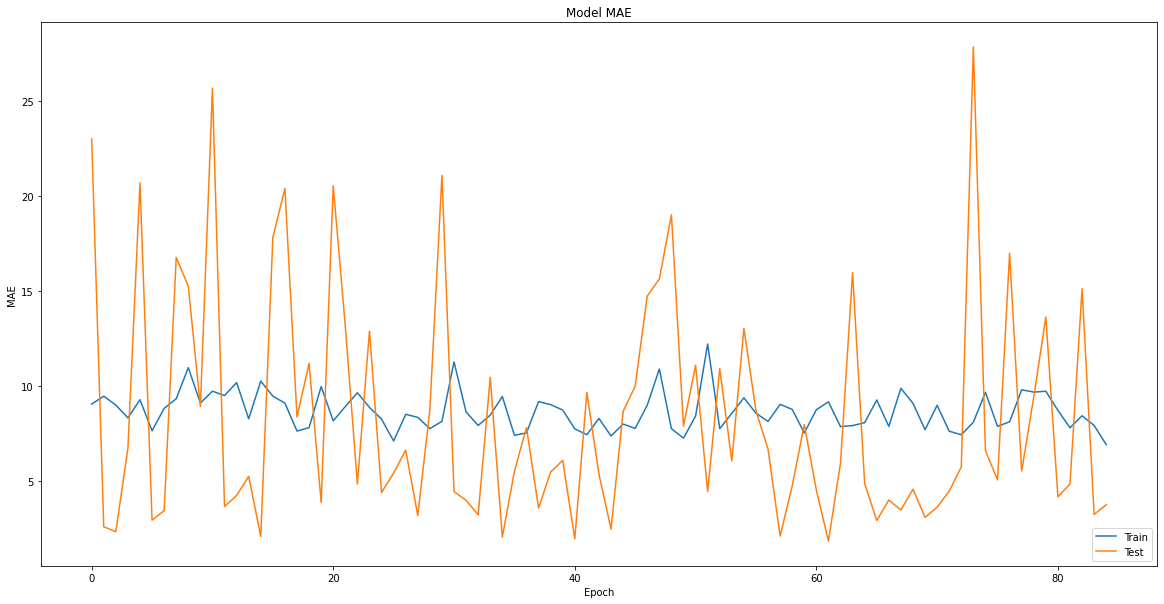

In [47]:
plt.figure(figsize=(20,10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='lower right')

plt.show()